# Physics-Informed Neural Networks (PINNs) for 1D Advection-Diffusion PDE
This notebook implements the concepts from Raissi's seminal [Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations](https://www.sciencedirect.com/science/article/pii/S0021999118307125) paper for the inverse problem.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.autograd import grad


#### Define PDE System

We want to study the inverse problem for the advection diffusion equation in 1D, which has various applications in the atmosphere and environment (e.g. simulating the effect of a point-source pollutant). In principle, the advection component models movement in one direction (downstream) whereas diffusion goes both ways regardless of a stream direction--this can be observed mathematically within the equation below. Since advection has a first-order derivative, changing direction will result in anti-symmetry. In comparison, diffusion's second-order derivative will maintain symmetry in either direction. Given the different scaling for advection and diffusion, one can compare these processes as a ratio of each other, which yeilds a dimensionless value formerly called the Peclet number. However, we will not explore the Peclet number in our formulation of the PINN.

The study of lagrangian particle transport has been researched extensively and can be read more about [here](https://www.sciencedirect.com/topics/earth-and-planetary-sciences/advection-diffusion-equation). An excerpt of the article is shown below as reference.

"""

In one dimension, this is given (after Okubo (1994) and Largier (2003)) by
\begin{aligned}
& \dfrac{\partial{C}}{\partial {t}} = -\dfrac{\partial}{\partial x} (uC) + \dfrac{\partial}{\partial x} \left( K_x \dfrac{\partial{C}}{\partial x} \right) + \lambda \\
\end{aligned}
where C is larval concentration at alongshore position x and time t, u the mean advective velocity over given time interval, Kx the local dispersion coefficient (eddy diffusivity) and λ the ‘reaction’ term, which here represents a source or sink.

The first term represents the rate of change of pollutant at a point. The second term is called the advection component and when combined with the first term represents the rate of change of pollutant in a unit of fluid along a streamline (considering the carrying fluid as incompressible). This is then balanced by the third term, the diffusion term, which represents the flux of pollutant out of a small unit of fluid travelling with the flow. 

"""

For stationary advection-diffusion problem in 1D, we have: 

\begin{aligned}
& \dfrac{\partial u}{\partial t} = c^2 \dfrac{\partial^2{u}}{\partial^2 {x}} - \beta \dfrac{\partial u}{\partial x}. 
\end{aligned}

For clarity, we can write this using subscript notation to indicate partial derivatives. 
\begin{aligned}
& u_t = c^2 u_{xx} - \beta u_x 
\end{aligned}

**Initial Conditions**
\begin{aligned}
u(x,0) = f(x)
\end{aligned}

**Dirichlet Boundary Conditions**
$$u(0,t) = u(L,t) = 0$$

#### Define parameters 

In [ ]:
# Parameters
c = 0.642               # Diffusion coefficient  
beta = 0.115            # Average velocity
xmin = -1               # Left boundary of the simulation domain
xmax = 1                # Right boundary of the simulation domain
L = xmax - xmin         # Domain length  
N_data_points = 100     # Number of data points to generate
N_time_points = 100     # Number of time points to generate

#### Testing Analytical Solution

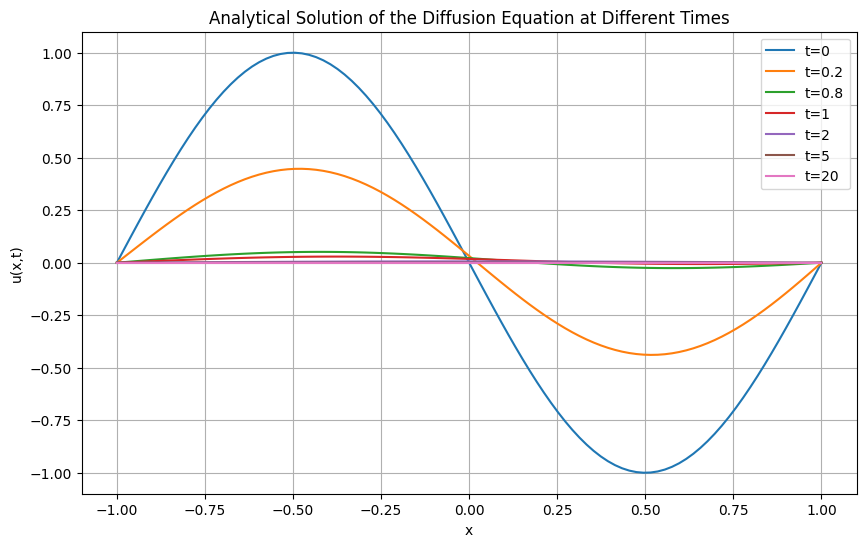

In [71]:
# Implements and plots analytical solution (based on the senior thesis paper)

# Define the initial condition function f(x)
def f(x):
    return -np.sin(np.pi * x)

# Compute the Fourier coefficient b_n
def compute_b_n(n, c, beta, L, f, xmin, N_integration_points=1000):
    x = np.linspace(0, L, N_integration_points)
    x_in_f = x + xmin  # Shift x back to [-1, 1]
    integrand = np.exp(-beta * x / (2 * c**2)) * f(x_in_f) * np.sin(n * np.pi * x / L)
    b_n = (2 / L) * np.trapz(integrand, x)
    return b_n

# Analytical solution function
def analytical_solution(t, x, c, beta, L, xmin, N_terms=50):
    x_shifted = x - xmin  # Shift x to [0, L]
    u_np = np.zeros_like(x)
    
    # Compute the exponential prefactors
    exp1 = np.exp(-beta**2 * t / (4 * c**2))
    exp2 = np.exp(beta * x_shifted / (2 * c**2))
    
    # Precompute b_n coefficients
    b_n_list = []
    for n in range(1, N_terms+1):
        b_n = compute_b_n(n, c, beta, L, f, xmin)
        b_n_list.append(b_n)
    
    for n, b_n in enumerate(b_n_list, start=1):
        n_pi_over_L = n * np.pi / L
        sin_npi_x_over_L = np.sin(n_pi_over_L * x_shifted)
        exp_term = np.exp(-c**2 * n_pi_over_L**2 * t)
        term = b_n * sin_npi_x_over_L * exp_term
        u_np += term
    
    # Multiply by the exponential prefactors
    u_np = exp1 * exp2 * u_np
    
    return u_np

# Generate spatial points
x = np.linspace(xmin, xmax, N_data_points) 

t_values = [0, 0.2, 0.8, 1, 2, 5, 20]  
plt.figure(figsize=(10, 6))
for t in t_values:
    u = analytical_solution(t, x, c, beta, L, xmin)
    plt.plot(x, u, label=f't={t}')
    
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Analytical Solution of the Diffusion Equation at Different Times')
plt.legend()
plt.grid(True)
plt.show()


#### Generate random dataset

In [3]:
# Generate spatial points and time points
x_values = np.linspace(xmin, xmax, N_data_points)
time_values = np.linspace(0, 0.5, N_time_points)

# Generate the solution data for u(t, x) at different time and spatial points
solution_data = []
for t in time_values:
    u = analytical_solution(t, x_values, c, beta, L, xmin)
    for x_val, u_val in zip(x_values, u):
        solution_data.append([t, x_val, u_val])

# Convert the solution data to a pandas DataFrame
df_solution = pd.DataFrame(solution_data, columns=['time', 'x', 'solution'])

# Save the solution data to a CSV file
df_solution.to_csv('AD_data_test.csv', index=False)


#### Define 1DAD PINN
Create NN architecture

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Read data
data = pd.read_csv('AD_data_test.csv')
t_train = torch.tensor(data['time'].values, dtype=torch.float32).view(-1, 1)
x_train = torch.tensor(data['x'].values, dtype=torch.float32).view(-1, 1)
u_train = torch.tensor(data['solution'].values, dtype=torch.float32).view(-1, 1)

# Define domain boundaries
xmin = x_train.min().item()
xmax = x_train.max().item()
tmin = t_train.min().item()
tmax = t_train.max().item()

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Define neural network layers
        self.hidden1 = nn.Linear(2, 50)
        self.hidden2 = nn.Linear(50, 50)
        self.hidden3 = nn.Linear(50, 50)
        self.hidden4 = nn.Linear(50, 50)
        self.output = nn.Linear(50, 1)
        self.activation = nn.Tanh()

        # Set initial guess for parameters
        self.c2 = nn.Parameter(torch.tensor([0.7], dtype=torch.float32))
        self.beta = nn.Parameter(torch.tensor([0.2], dtype=torch.float32))

    def forward(self, x, t):
        # Forward pass
        input = torch.cat((x, t), dim=1)
        out = self.activation(self.hidden1(input))
        out = self.activation(self.hidden2(out))
        out = self.activation(self.hidden3(out))
        out = self.activation(self.hidden4(out))
        out = self.output(out)
        return out


#### Create loss function & train PINN

In [ ]:
# Initialize model
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # higher learning rate = learns faster
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.1)
loss_fn = nn.MSELoss()

num_epochs = 10000
print_every = 100
all_total_loss = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    x_train = x_train.detach().requires_grad_(True)
    t_train = t_train.detach().requires_grad_(True)
    
    # Forward pass at training data points
    u_pred = model(x_train, t_train)
    # Compute data loss
    data_loss = loss_fn(u_pred, u_train)
    
    # Generate collocation points for physics loss (points at which we make predictions using the model)
    N_collocation = 1000
    x_collocation = torch.FloatTensor(N_collocation, 1).uniform_(xmin, xmax).requires_grad_(True)
    t_collocation = torch.FloatTensor(N_collocation, 1).uniform_(tmin, tmax).requires_grad_(True)
    
    # Forward pass at collocation points
    u_pred_collocation = model(x_collocation, t_collocation)
    
    # Compute derivatives at collocation points
    u_t = torch.autograd.grad(u_pred_collocation, t_collocation, grad_outputs=torch.ones_like(u_pred_collocation), create_graph=True)[0]
    u_x = torch.autograd.grad(u_pred_collocation, x_collocation, grad_outputs=torch.ones_like(u_pred_collocation), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_collocation, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    
    # Compute PDE residual at collocation points
    c2 = model.c2
    beta = model.beta
    residual = u_t + beta * u_x - c2 * u_xx
    physics_loss = loss_fn(residual, torch.zeros_like(residual))
    
    # Initial condition
    N_ic = 100  # Number of initial condition points
    x_ic = torch.linspace(xmin, xmax, N_ic).view(-1, 1)
    t_ic = torch.full_like(x_ic, tmin)
    u_ic_pred = model(x_ic, t_ic)
    
    # Redefining IC in terms of torch
    #def IC(x):
    #    return -torch.sin(np.pi * x)
    
    u_ic_true = f(x_ic)
    ic_loss = loss_fn(u_ic_pred, u_ic_true)
    
    # Boundary conditions at x = xmin and x = xmax
    N_bc = 100  # Number of boundary condition points
    t_bc = torch.linspace(tmin, tmax, N_bc).view(-1, 1)
    x_bc_min = torch.full_like(t_bc, xmin)
    x_bc_max = torch.full_like(t_bc, xmax)
    u_bc_min_pred = model(x_bc_min, t_bc)
    u_bc_max_pred = model(x_bc_max, t_bc)
    
    # Assuming Dirichlet boundary conditions u = 0 at x = xmin and x = xmax
    u_bc_true = torch.zeros_like(t_bc)
    bc_loss = loss_fn(u_bc_min_pred, u_bc_true) + loss_fn(u_bc_max_pred, u_bc_true)
    
    # Total loss
    loss = data_loss + physics_loss + bc_loss + ic_loss

    all_total_loss.append(loss)
    """
    lambda_data = 0.5
    lambda_phys = 1.0
    lambda_bc = 0.25
    lambda_ic = 0.25
    loss = (lambda_data * data_loss +
            lambda_phys * physics_loss +
            lambda_bc * bc_loss + 
            lambda_ic * ic_loss)
    """
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    if epoch % print_every == 0:
        print(f"Epoch {epoch}, Total Loss: {loss.item():.6f}, Data Loss: {data_loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}, c^2: {np.sqrt(c2.item()):.6f}, beta: {beta.item():.6f}")

#### Create animation of results

Visualize the solution and error through time against the analytial solution.

In [ ]:
#### POST - TRAINING ####
c2_learned = model.c2.item()
beta_learned = model.beta.item()

print(f"Learned c^2: {c2_learned}")
print(f"Learned beta: {beta_learned}")

c_actual = 0.642   # Diffusion coefficient  
beta_actual = 0.115 # Average velocity
xmin = -1    # Left boundary of the simulation domain
xmax = 1  # Right boundary of the simulation domain
L = xmax - xmin    # Domain length  
N_data_points = 1000   # Number of data points to generate

def f(x):
    return -np.sin(np.pi * x)

# Compute the Fourier coefficient b_n
def compute_b_n(n, c, beta, L, f, xmin, N_integration_points=1000):
    x = np.linspace(0, L, N_integration_points)
    x_in_f = x + xmin  # Shift x back to [-1, 1]
    integrand = np.exp(-beta * x / (2 * c**2)) * f(x_in_f) * np.sin(n * np.pi * x / L)
    b_n = (2 / L) * np.trapz(integrand, x)
    return b_n

# Analytical solution function
def analytical_solution(t, x, c, beta, L, xmin, N_terms=50):
    x_shifted = x - xmin  # Shift x to [0, L]
    u_np = np.zeros_like(x)
    
    # Compute the exponential prefactors
    exp1 = np.exp(-beta**2 * t / (4 * c**2))
    exp2 = np.exp(beta * x_shifted / (2 * c**2))
    
    # Precompute b_n coefficients
    b_n_list = []
    for n in range(1, N_terms+1):
        b_n = compute_b_n(n, c, beta, L, f, xmin)
        b_n_list.append(b_n)
    
    for n, b_n in enumerate(b_n_list, start=1):
        n_pi_over_L = n * np.pi / L
        sin_npi_x_over_L = np.sin(n_pi_over_L * x_shifted)
        exp_term = np.exp(-c**2 * n_pi_over_L**2 * t)
        term = b_n * sin_npi_x_over_L * exp_term
        u_np += term
    
    # Multiply by the exponential prefactors
    u_np = exp1 * exp2 * u_np
    
    return u_np

# Generate spatial points
x = np.linspace(xmin, xmax, N_data_points)
x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1)
x_tensor.requires_grad_(True)
t_values = np.linspace(0, 0.5, 250)

# Prepare for animation
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
line1, = ax[0].plot([], [], label='Analytical Solution')
line2, = ax[0].plot([], [], label='PINN Solution')
ax[0].set_xlim(xmin, xmax)
ax[0].set_ylim(-1.5, 1.5)
ax[0].set_xlabel('x')
ax[0].set_ylabel('u(x,t)')
ax[0].set_title('Solution at Different Times')
ax[0].legend()
ax[0].grid(True)

line3, = ax[1].plot([], [], label='Error')
ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(-0.5, 0.5)
ax[1].set_xlabel('x')
ax[1].set_ylabel('Error')
ax[1].set_title('Error between PINN and Analytical Solution')
ax[1].legend()
ax[1].grid(True)

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    line3.set_data([], [])
    return line1, line2, line3

def animate(t):
    t_value = t
    t_array = t_value * np.ones_like(x)
    t_tensor = torch.tensor(t_array, dtype=torch.float32).view(-1, 1)
    
    # Analytical solution
    u_analytical = analytical_solution(t_value, x, c_actual, beta_actual, L, xmin)
    
    # PINN solution
    model.eval()
    with torch.no_grad():
        u_pinn = model(x_tensor, t_tensor).numpy().flatten()
    
    # Error
    error = u_pinn - u_analytical
    
    line1.set_data(x, u_analytical)
    line2.set_data(x, u_pinn)
    line3.set_data(x, error)
    ax[0].set_title(f'Solution at t = {t_value:.2f}')
    return line1, line2, line3

anim = FuncAnimation(fig, animate, frames=t_values, init_func=init, blit=True, interval=100)

plt.tight_layout()
plt.show()

anim.save('pinn_animation.gif', writer='imagemagick', fps=15)


#### Visualize loss  metrics

<Figure size 640x480 with 0 Axes>

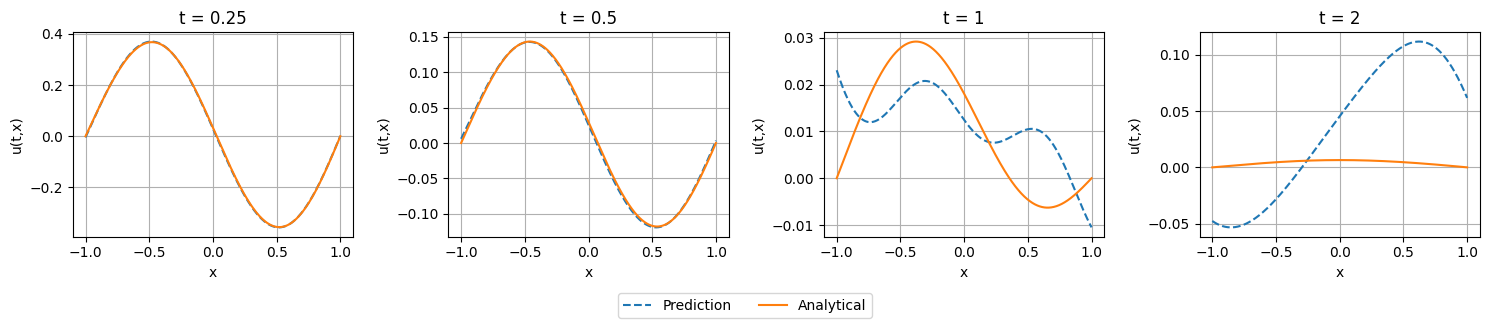

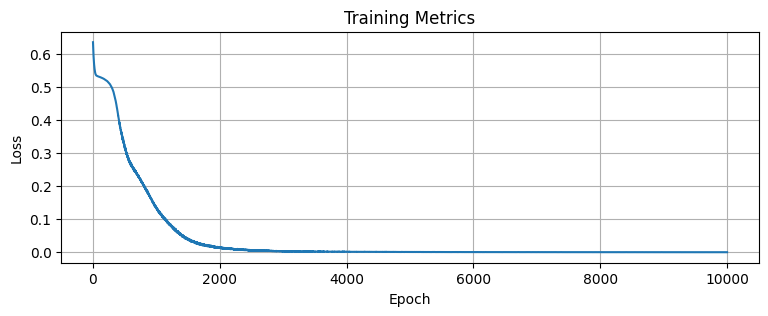

In [70]:
plt.figure()
x = np.linspace(xmin, xmax, N_data_points)
t_value = [0.25, 0.5, 1, 2]

fig, axs = plt.subplots(ncols=4, figsize=(15, 3))
#plt.subplots_adjust(hspace=3)

for idx, val in enumerate(t_value):
    t_array = t_value[idx] * np.ones_like(x)
    t_tensor = torch.tensor(t_array, dtype=torch.float32).view(-1, 1)
    #print(t_tensor)
    model.eval()

    with torch.no_grad():
        u_pinn = model(x_tensor, t_tensor).numpy().flatten()    
        axs[idx].plot(x, u_pinn, '--', label = 'Prediction')
        axs[idx].plot(x, analytical_solution(t_value[idx], x, c_actual, beta_actual, L, xmin), label='Analytical')
        axs[idx].set_title(f't = {t_value[idx]}')
        axs[idx].set_xlabel("x")
        axs[idx].set_ylabel("u(t,x)")
        axs[idx].grid()

# create a common legend for the whole figure
handles, labels = axs[0].get_legend_handles_labels()  # Get labels from one subplot
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))
fig.tight_layout()


plt.figure(figsize=(9,3))
#print(range(num_epochs))
plt.plot(range(num_epochs), [loss_tensor.detach().numpy() for loss_tensor in all_total_loss])
plt.title('Training Metrics')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()



In [ ]:
# future ideas:
# predictor corrector, update initial guess if lr overshoots
# implicit, arc length corrector 